# Assignment 4 - Image Denoising with Deep CNNs

### Name: Anirudh Swaminathan
### PID: A53316083
### Email ID: aswamina@eng.ucsd.edu

#### Notebook created by Anirudh Swaminathan from ECE department majoring in Intelligent Systems, Robotics and Control for the course ECE285 Machine Learning for Image Processing for Fall 2019

## Getting Started

In [2]:
%matplotlib notebook

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt

In [3]:
# select the relevant device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Creating noisy images of BSDS dataset with DataSet

#### Question 1

In [4]:
dataset_root_dir = '/datasets/ee285f-public/bsds/'

We have created the $dataset\_root\_dir$ and made it point to the BSDS dataset directory. 

#### Question 2

In [5]:
class NoisyBSDSDataset(td.Dataset):
    
    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=30):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)
        
    def __len__(self):
        return len(self.files)
    
    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})".format(self.mode, self.image_size, self.sigma)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        
        # Read the original image
        clean = Image.open(img_path).convert('RGB')
        
        # choose i as random index to start the row crop from
        i = np.random.randint(clean.size[0] - self.image_size[0])
        
        # choose j as the random index to start the column crop from
        j = np.random.randint(clean.size[1] - self.image_size[1])
        # COMPLETE
        # crop the image
        clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])
        
        # transform and normalize
        transform = tv.transforms.Compose([
            # convert to torch tensor
            tv.transforms.ToTensor(),
            
            # Normalize each channel from [-1, 1]
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        
        # apply the transform on the image
        clean = transform(clean)
        
        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)
        return noisy, clean

I initially cropped the image to the requried image_size from the random indices that were generated using the $.crop()$ method. <br>
Then the image is converted to a torch tensor using the $tv.transforms.ToTensor()$ function. <br>
$$\textbf{NOTE:-} \text{The }tv.trasforms.ToTensor() \text{ converts the PIL image from range }(0, 255) \text{ to a tensor of range }(0, 1)$$
Finally, I normalize the image using the $tv.transforms.Normalize()$ function. <br>
This function takes means and standard deviations for each channel as the input. Since each channel has been transformed to $(0, 1)$ by the $tv.transforms.ToTensor()$ function, we have the mean for each channel is $0.5$ and the standard deviation is $0.5$. <br>
As given in the $PyTorch$ source code and documentation, the $tv.transforms.Normalize()$ function subtracts the mean for each channel from the image, and then divides by the standard deviation, so now the tensor in the range from $(0, 1)$ is converted to $\left( \frac{(0-0.5)}{0.5}, \frac{(1-0.5)}{0.5} \right)$, which is $(-1, 1)$. <br>
Finallly, as given in the question, the noisy image is generated by creating a torch tensor whose elements are individually sampled from the standard normal distribution $\mathcal{N} \sim \left(0, 1\right)$. <br>
This is then multiplied with the $\sigma$ that we require to convert it to $\mathcal{N} \sim \left(0, \sigma \right)$. <br>
Finally, the noisy image is normalized using the $\frac{2}{255}$ to ensure it is in the range of $(-1, 1)$.
This is because the $\sigma$ was for the origial pixel values with range from $0$ to $255$ and so, we divide by $255$. <br>
As discussed in Piazza, we then multiply by $2$ as the range of the values are doubled from $(0, 1)$ to $(-1, 1)$. <br>
Finally the noisy image is distributed as follows:- 
$$\text{noisy image} = \text{clean image} + \mathcal{N} \sim \left(0, \frac{2\sigma}{255}\right)$$

#### Question 3

In [6]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image<0] = 0
    image[image>1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [7]:
# consider training set and the testing set from this class
train_set = NoisyBSDSDataset(root_dir=dataset_root_dir)
test_set = NoisyBSDSDataset(root_dir=dataset_root_dir, mode="test", image_size=(320, 320))

In [7]:
# 12th index image in the testing set
x = test_set.__getitem__(12)
noi = x[0]
cle = x[1]

In [8]:
print(type(noi), noi.dtype, noi.size(), noi.min(), noi.max())
print(type(cle), cle.dtype, cle.size(), cle.min(), cle.max())

<class 'torch.Tensor'> torch.float32 torch.Size([3, 320, 320]) tensor(-1.7780) tensor(1.8739)
<class 'torch.Tensor'> torch.float32 torch.Size([3, 320, 320]) tensor(-1.) tensor(1.)


<IPython.core.display.Javascript object>


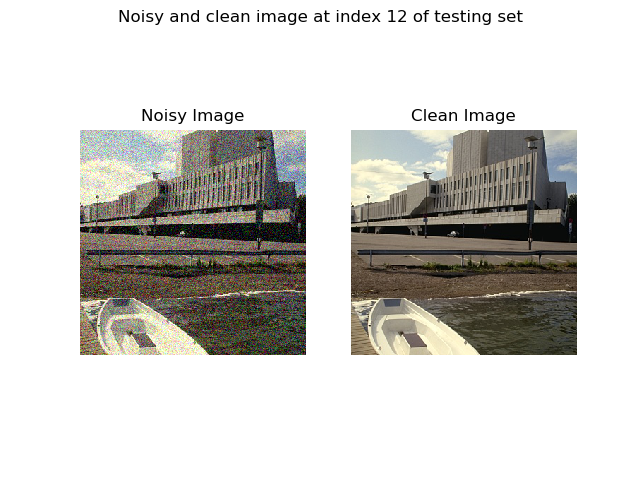

Text(0.5, 1.0, 'Clean Image')

In [9]:
# Display Noisy and Clean image for the 12th index of the testing set
fig, axes = plt.subplots(ncols=2)
fig.suptitle("Noisy and clean image at index 12 of testing set")

myimshow(noi, ax=axes[0])
axes[0].set_title("Noisy Image")

myimshow(cle, ax=axes[1])
axes[1].set_title("Clean Image")

Created $train\_set$ and $test\_set$ as instances of the $NoisyBSDSDataset$ class. <br>
Retrieved the item at index $12$ from the $test\_set$. <br>
Displayed the noisy and the clean images side-by-side for the $12^{th}$ index of the testing set, using the $myimshow()$ function that was given to us in the previous assignment.

## DnCNN

#### Question 4

In [8]:
# NNRegressor -> inherits from NeuralNetwork and implements criterion as MSE loss
class NNRegressor(nt.NeuralNetwork):
    
    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()
        
    def criterion(self, y, d):
        return self.mse(y, d)

I have now defined the class $NNRegressor$ that inherits from $NeuralNetwork$. <br>
I wrote that the $criterion$ must now be $MSELoss$ for the class $NNRegressor$.  <br>
This class is still abstract, as the $forward()$ method is still unimplemented.

#### Question 5

In [9]:
class DnCNN(NNRegressor):
    
    def __init__(self, D, C=64):
        """ Constructor
        D - Number of repetiitons of Conv + BN + ReLU
        C - Number of feature maps for each Conv layer
            default - 64
        """
        super(DnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        
        # here padding=1 as we want to maintain the same size of the feature maps as given in input
        # this translates to "same" in convolutions, which means that we need to pad by (n-1)/2
        # hence, padding = (3-1)/2 = (2/2) = 1
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        # COMPLETE
        # I need to add D conv layers after this
        for k in range(D):
            self.conv.append(nn.Conv2d(C, C, 3, padding=1))
        
        # Add the final conv from 64 back to 3 feature maps
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        # BN layers
        self.bn = nn.ModuleList()
        
        # Append all the D Batch norm layers
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C))
            
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        # COMPLETE
        # forward through all the layers
        for k in range(D):
            h = self.conv[k+1](h)
            h = F.relu(self.bn[k](h))
        # final layer forward
        # the x is added as a skip connection - ResNet
        y = self.conv[D+1](h) + x
        return y

I have now implemented the $DnCNN$ model, which inherits from $NNRegressor$. <br>
As given in the question, my $1^{st}$ convolution layer will take in $3$ feature maps and output $C = 64$ feature maps of equal size after $3 x 3$ convlutions. <br>
In order to preserve the spatial feature dimensions between each successive layer of the network, we will have to use $0-$ padding. <br>
$$\textbf{Zero-padding calculation}$$
Our convolutional filter size is $3 x 3$. We need to output feature maps that are the same size as the input feature maps by using zero-padding. <br>
For a convolutional filter of size $n = 3$, the amount of zero-padding required for "same" convolution is given by
$$p = \frac{n - 1}{2} = \frac{3 - 1}{2} = \frac{2}{2} = 1$$
Hence, we give padding = $1$. <br>
$$\textbf{Adding the Conv layers}$$
The $1^{st}$ conv layer converts the input $3$ channels to $C$ channels, with the padding = $1$ to maintain the same size of the feature maps through the layers as argued above. <br>
We first append this layer to the $self.conv$ variable which is an instance of the $ModuleList$ object. <br>
We have $D = 6$ conv layers that repeat, so we iteratively append conv layers $D$ times, where each takes in $C$ features in the input, and outputs $C$ features, to the $self.conv$ variable which is a $ModuleList$ object. <br>
The padding is $1$ as argued above, to maintain the same size of feature maps through the layers. <br>
The final conv layer that is appended is the one that converts $C$ input features to $3$ output features back again. The padding still remains $1$ to ensure the size of the feature maps remains the same as argued above. <br>
Thus, we have a total of $D + 2$ conv layers in the $self.conv$ $ModuleList$, which are indexed from $0$ to $D + 1$. <br>
$$\textbf{Adding the BatchNorm layers}$$
We have a total of $D$ $BatchNorm2d$ layers. We iteratively append bn layers $D$ times, where each takes in $C$ features in the input, to the $self.bn$ variable which is a $ModuleList$ object. <br>
Thus, we have a total of $D$ bn layers in the $self.bn$ $ModuleList$, which are indexed from $0$ to $D - 1$. <br>
$$\textbf{Implementing the forward() method}$$
In the $forward()$ method, as given in the question, I sequentially pass the input tensor $x$ through the $1^{st}$ conv layer, which is given by the index $0$ of the $self.conv$ $ModuleList$ object. <br>
I then iteratively pass the tensor obtained from the previous step through the $D$ conv layers first, and then through the $D$ BN layers. <br>
$\textbf{Indexing}$ Since I've already used the $1^{st}$ conv layer initially, my index in the iteration for conv layers from the $self.conv$ $ModuleList$ object is $k + 1$, where $k$ denotes the iteration index. <br>
The index for the $BatchNorm2d$ layers remains $k$, as all my $D$ bn layers are yet to be applied. <br>
I additionally pass the tensor obtained from each bn layer through $ReLU$. <br>
I apply the final conv layer on the tensor obtained after $D$ iterations, using the index $D + 1$. This is the $(D + 2)^{th}$ element of the $self.conv$ $ModuleList$ object. This conv layer converts the $C$ feature maps obtained back to $3$ feature maps, with the same image size with padding = $1$ as argued above. <br>
I then add the input tensor $x$ to this output, thus implementing my skip-connection. <br><br>
I finally implemented the $forward()$ method of my network and thus, this class is no longer an abstract class.

#### Question 6

In [10]:
class DenoisingStatsManager(nt.StatsManager):
    
    def __init__(self):
        super(DenoisingStatsManager, self).__init__()
        
    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0
        
    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)
        
        # compute the difference for all 3 channels for all the images in the minibatch
        diff = y - d
        
        # calculate the total number of elements in the tensor
        n = y.numel()
        
        # calaulate the difference squared
        diff_sq = diff ** 2
        
        # calculate the norm squared
        norm_sq = torch.sum(diff_sq)
        
        # psnr is now taken
        psnr = 10 * torch.log10((4 * n) / norm_sq)
        self.running_psnr += psnr
        
    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        
        # average psnr when called
        psnr_avg = self.running_psnr / self.number_update
        return {'loss' : loss, 'psnr' : psnr_avg}

Created a subclass $DenoisingStatsManager$ that inherits from $StatsManager$ and overloads each method. <br>
The PSNR is calculated by the given formula
$$PSNR = 10 \log_{10} \left( \frac{4n}{\| y - d \|_2^2} \right)$$
I find the total number of elements in the input tensor, which is given by
$$n = \text{Number of elements in minibatch} * \text{Number of channels} * \text{Image Width} * \text{Image Height}$$
I calculate $\| y - d \|_2^2$ as the sum of the errors squared of $y$ and $d$. <br>
The additional information apart from the running loss is the running PSNR that is also being tracked here. <br>
In $init()$, the running PSNR is set to $0$. The $accumulate()$ method adds the PSNR for each minibatch to the running PSNR. <br>
Finally, the $summarize()$ method is overloaded to set the PSNR to the average over all the updates in the epoch. <br>

#### Question 7

In [11]:
# DnCNN network
lr = 1e-3

# create dncnn with D = 6
dncnn_net = DnCNN(D=6)

# transferred the net to GPU
dncnn_net = dncnn_net.to(device)
adam = torch.optim.Adam(dncnn_net.parameters(), lr=lr)
dncnn_stats_manager = DenoisingStatsManager()
exp1 = nt.Experiment(dncnn_net, train_set, test_set, adam,
                     dncnn_stats_manager, output_dir="denoising1",
                     batch_size=4, perform_validation_during_training=True)

I have created a $DnCNN$ network with $D = 6$ and transferred it to the $GPU$. <br>
I also created and experiment for $DnCNN$ named $exp1$ using Adam optimizer with learning rate as $10^-3$. <br>
I am using an instance of the $DenoisingStatsManager$ class for computing statistics. <br>
Finally, I am using mini-batches of size $4$ and store the checkpoints in $denoising1$ directory. <br>
I finally checked that the directory has been created.

#### Question 8

In [14]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[np.newaxis].to(exp.net.device))[0]
    
    # setup the axes
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    
    # show the noisy image
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title("Noisy image")
    
    # COMPLETE
    # show the denoised image
    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title("Denoised image")
    
    # plots now
    # Plot the training loss over the epochs
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="training loss")
    # Plot the evaluation loss over the epochs
    axes[1][0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)], color='orange', label="test loss")
    # legend for the plot
    axes[1][0].legend()
    # xlabel and ylabel
    axes[1][0].set_xlabel("Epoch")
    axes[1][0].set_ylabel("Loss")
    
    # Plot the training PSNR over the epochs
    axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)], label="training psnr")
    # Plot the evaluation PSNR over the epochs
    axes[1][1].plot([exp.history[k][1]['psnr'] for k in range(exp.epoch)], color='orange', label="test psnr")
    # legend for the plot
    axes[1][1].legend()
    # xlabel and ylabel
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("PSNR")
    
    plt.tight_layout()
    fig.canvas.draw()

I have completed the $plot()$ function to plot the original and denoised images and the different metrics for $200$ epochs. <br>
I use a $4*4$ subplots for the same. <br>
The $1^{st}$ row of plot is for the noisy and the denoised image respectively. <br> 
The next row corresponds to the loss and PSNR. <br>
I access the $k^{th}$ epoch using the $history[k]$ index. <br>
I then access the metrics evaluated on the training set using the $0^{th}$ index. <br>
To access the loss, we use the loss as key value for the dictionary. To access the PSNR, we use psnr as the key value for the dictionary. <br>
To set the X Label and Y Label for each subplot, we use the $set\_xlabel()$ and the $set\_ylabel()$ methods respectively. <br>
To set the legend for the subplots, since we have already specified the $label$ for each subplot, we just need to call the $legend()$ function for each subplot. <br>

<IPython.core.display.Javascript object>


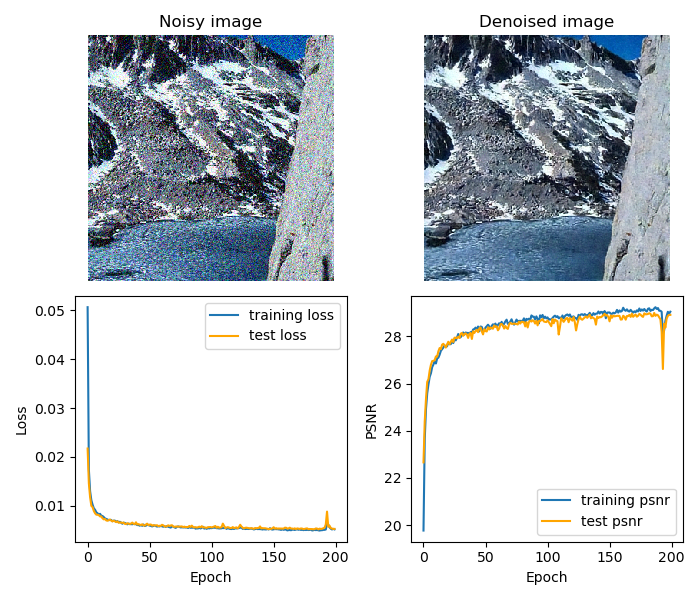

Start/Continue training from epoch 25
Epoch 26 (Time: 12.82s)
Epoch 27 (Time: 12.27s)
Epoch 28 (Time: 12.55s)
Epoch 29 (Time: 12.38s)
Epoch 30 (Time: 12.39s)
Epoch 31 (Time: 12.55s)
Epoch 32 (Time: 12.67s)
Epoch 33 (Time: 12.44s)
Epoch 34 (Time: 12.45s)
Epoch 35 (Time: 12.51s)
Epoch 36 (Time: 12.30s)
Epoch 37 (Time: 12.59s)
Epoch 38 (Time: 12.42s)
Epoch 39 (Time: 12.27s)
Epoch 40 (Time: 12.33s)
Epoch 41 (Time: 12.46s)
Epoch 42 (Time: 12.57s)
Epoch 43 (Time: 12.28s)
Epoch 44 (Time: 12.43s)
Epoch 45 (Time: 12.05s)
Epoch 46 (Time: 12.20s)
Epoch 47 (Time: 12.29s)
Epoch 48 (Time: 12.35s)
Epoch 49 (Time: 12.55s)
Epoch 50 (Time: 12.43s)
Epoch 51 (Time: 12.29s)
Epoch 52 (Time: 12.39s)
Epoch 53 (Time: 11.84s)
Epoch 54 (Time: 12.40s)
Epoch 55 (Time: 12.40s)
Epoch 56 (Time: 12.85s)
Epoch 57 (Time: 12.33s)
Epoch 58 (Time: 12.68s)
Epoch 59 (Time: 12.54s)
Epoch 60 (Time: 12.67s)
Epoch 61 (Time: 12.33s)
Epoch 62 (Time: 13.03s)
Epoch 63 (Time: 12.45s)
Epoch 64 (Time: 12.37s)
Epoch 65 (Time: 12.15s)
Ep

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7, 6))
exp1.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes, noisy=test_set[73][0]))

I have run the $1^{st}$ experiment using $DnCNN$ for Denosing on the GPU, with Adam Optimizer and with learning rate = $1^{-3}$. <br>
The training has been completed for $200$ epochs, and we have got $2$ plots, one each for loss and PSNR for the training and the testing set with the number of epochs. <br>
For each epoch, it takes about $13$ seconds to run on the GPU. <br>
I've also plotted a random noisy image from the test set and it's denoised version and tracked its evolution through the training over $200$ epochs.<br>

#### Question 9

<IPython.core.display.Javascript object>


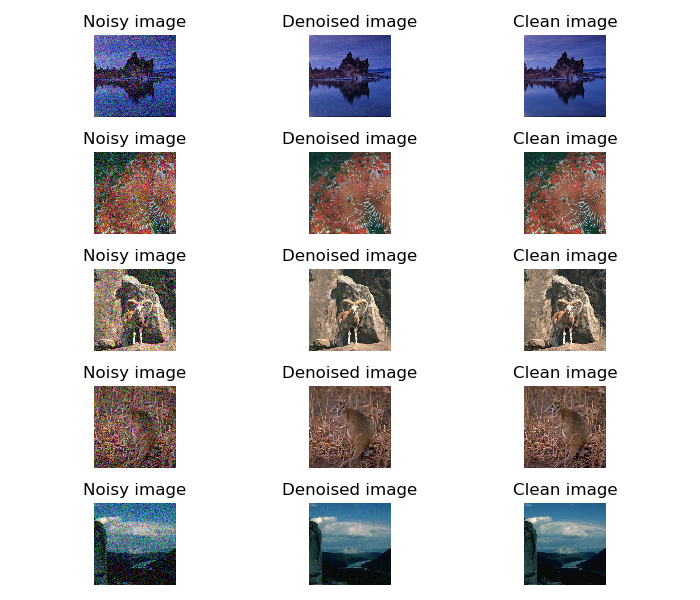

In [15]:
# Comparing the noisy, clean and denoised image results of a few images of the testing set
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(7, 6), sharex='all', sharey='all')
for i in range(5):
    ind = np.random.randint(0, len(test_set))
    noi, cle = test_set[ind]
    with torch.no_grad():
        den = exp1.net(noi[np.newaxis].to(exp1.net.device))[0]
    myimshow(noi, ax=axes[i][0])
    axes[i][0].set_title("Noisy image")
    # show the denoised image
    myimshow(den, ax=axes[i][1])
    axes[i][1].set_title("Denoised image")
    myimshow(cle, ax=axes[i][2])
    axes[i][2].set_title("Clean image")
plt.tight_layout()
fig.canvas.draw()

I plotted the noisy image, denoised image and clean image for $5$ random indices from the test set. <br>
On visual inspection, I find that the denoised image looks very to the clean image than the noisy image. <br>
But, I do find some loss of information. For example, in one of the random images, the edges of an object are blurred in the denoised image when compared to the clean image. <br>
In another image, clouds are slighly merged with each other, while the clean image is better in that sense. <br>

#### Question 10

$$\textbf{Number of Parameters Calculation}$$
The number of parameters of $DnCNN$ are from the conv and batchnorm layers only. <br>
The $1^{st}$ conv layer contributes $3*64*3*3 = 1728$ weight parameters. <br>
The $1^{st}$ conv layer contributes $64$ bias parameters, i.e., one parameter for each feature map. <br>
The next $D$ conv layers contribute $64*64*3*3 = 36864$ weight parameters each, totalling to $D*36864$ weight parameters. <br>
These $D$ conv layers contribute $64$ bias parameters each, totalling to $D*64$ bias parameters. <br>
The Batchnorm2d layer contributes $2$ parameters to each feature map, which is $64*2 = 128$ parameters. Then, $D$ layers contribute $128*D$ parameters. <br>
The final conv layer contributes $3*64*3*3 = 1728$ weight parameters. <br>
The final conv layer contributes $3$ bias parameters, i.e., one parameter for each feature map. <br>
The total number of parameters is thus as follows:-
$$\text{Number of parameters } = (3*64*3*3) + (64) + (D*64*64*3*3) + (D*64) + (D*64*2) + (3*64*3*3) + 3 = 37056D + 3523$$
For the specific case of $D=6$, the number of parameters is $37056*6 + 3523 = 225859$
$$\textbf{Receptive field calculation}$$
The final conv layer, is $3*3$, so the receptive field of the output pixel to this layer is $3*3$. <br>
Now, for each conv layer before this, since it is a $3*3$ conv, we have increase in receptive field by $1$ in each of width and height. <br>
So, receptive field of output pixel at layer $k$ is $2$ + receptive field of output pixel at layer $k+1$. <br>
So, after $D$ layers to input, the receptive field of output pixel is $(3+(D*2))*(3+(D*2))$ <br>
Finally, the $1^{st}$ conv layer also adds $1$ pixel to each of width and height, thus giving $(3+(D*2)+2)*(3+(D*2)+2)$ <br>
Hence, the receptive field of $DnCNN(D)$ is given by
$$\text{Receptive field } = 3 + (D*2) + 2 = 1 + (D+2)*2 = 2D + 5$$
For the specific case of $D = 6$, we have receptive field = $2*6 + 5 = 12 + 5 = 17$. <br>
Hence, $(2D + 5)*(2D + 5)$ input pixels influence an output pixel.

#### Question 11

For the receptive field to be $33 * 33$, we must have $33 = 2D + 5$ as discussed in the previous question. <br>
Hence, for this to occur, the DnCNN should have a depth $\textbf{D = 14}$. <br>
For a depth $D=14$, the number of parameters as found in the previous question would now become $37056*14 + 3523 = 522307$ <br>
This is more than twice the number of parameters of we have used, thus increasing the computation time by $2$ times.

#### Question 12

In [12]:
class UDnCNN(NNRegressor):
    
    def __init__(self, D, C=64):
        """ Constructor
        D - Number of repetiitons of Conv + BN + ReLU
        C - Number of feature maps for each Conv layer
            default - 64
        """
        super(UDnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        
        # here padding=1 as we want to maintain the same size of the feature maps as given in input
        # this translates to "same" in convolutions, which means that we need to pad by (n-1)/2
        # hence, padding = (3-1)/2 = (2/2) = 1
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        # COMPLETE
        # I need to add D conv layers after this
        for k in range(D):
            self.conv.append(nn.Conv2d(C, C, 3, padding=1))
        
        # Add the final conv from 64 back to 3 feature maps
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        # BN layers
        self.bn = nn.ModuleList()
        
        # Append all the D Batch norm layers
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C))
            
    def forward(self, x):
        D = self.D
        # list to store the features
        feats = []
        
        # list to store the spatial dimensions
        spats = []
        
        # list to store the maxpool indices for the unpool operation
        mpinds = []
        
        # Layer 1
        h = F.relu(self.conv[0](x))
        feats.append(h)
        # forward through D layers
        for k in range(D):
            # contractive pooling layers
            if k < D/2 - 1:
                h = self.conv[k+1](h)
                h = F.relu(self.bn[k](h))
                spats.append(h.size())
                h, inds = F.max_pool2d(h, 2, return_indices=True)
                mpinds.append(inds)
                feats.append(h)
            # expansive unpooling layers
            elif k > D/2:
                h = F.max_unpool2d(h, mpinds[D-k-1], output_size=spats[D-k-1], kernel_size=2)
                h = self.conv[k+1](h)
                h = F.relu(self.bn[k](h))
                h = (h + feats[D-k-1]) / np.sqrt(2)
            # middle 2 layers
            else:
                h = self.conv[k+1](h)
                h = F.relu(self.bn[k](h))
            # first addition operation after middle layer
            if k==D/2:
                h = (h + feats[D-k-1]) / np.sqrt(2)
        
        # final layer forward
        # the x is added as a skip connection - ResNet
        y = self.conv[D+1](h) + x
        return y

I have now implemented the $UDnCNN$ model, which inherits from $NNRegressor$. <br>
The only difference between $DnCNN$ and $UDnCNN$ is in the way the $forward()$ method is implemented, as all the conv and bn layers are of the same number and of the same feature map sizes. <br> 
$$\textbf{Implementing the forward() method}$$
In the $forward()$ method, as given in the question, I sequentially pass the input tensor $x$ through the $1^{st}$ conv layer, which is given by the index $0$ of the $self.conv$ $ModuleList$ object. <br>
I then iteratively pass the tensor obtained from the previous step through the $D$ conv layers first, and then through the $D$ BN layers. <br>
For the contractive pooling layers, since the index is less than $(D/2)-1$ I store the spatial dimension before pooling, perform pooling operation and obtain the max pool indices required for unpooling. <br>
For the expansive unpooling layers, since the index is greater than $(D/2)$, I unpool them, go through Conv, BN and ReLU, and then add it to the feature map in the $(D-k-1)^{th}$ layer. <br>
Finally, in those layers with neither pooling nor unpooling, I simply pass the input through Conv, BN, and ReLU. Additionally, I add the $1^{st}$ expansive layers output with the feature map of the final pooling layer before passing it on to the $1^{st}$ unpooling layer. <br>
I finally implemented the $forward()$ method of my network and thus, this class is no longer an abstract class.

#### Question 13

In [13]:
# UDnCNN network
lr = 1e-3

# create dncnn with D = 6
udncnn_net = UDnCNN(D=6)

# transferred the net to GPU
udncnn_net = udncnn_net.to(device)
adam = torch.optim.Adam(udncnn_net.parameters(), lr=lr)
udncnn_stats_manager = DenoisingStatsManager()
exp2 = nt.Experiment(udncnn_net, train_set, test_set, adam,
                     udncnn_stats_manager, output_dir="denoising2",
                     batch_size=4, perform_validation_during_training=True)

I have created a $UDnCNN$ network with $D = 6$ and transferred it to the $GPU$. <br>
I also created and experiment for $UDnCNN$ named $exp2$ using Adam optimizer with learning rate as $10^-3$. <br>
I am using an instance of the $DenoisingStatsManager$ class for computing statistics. <br>
Finally, I am using mini-batches of size $4$ and store the checkpoints in $denoising2$ directory. <br>
I finally checked that the directory has been created.

<IPython.core.display.Javascript object>


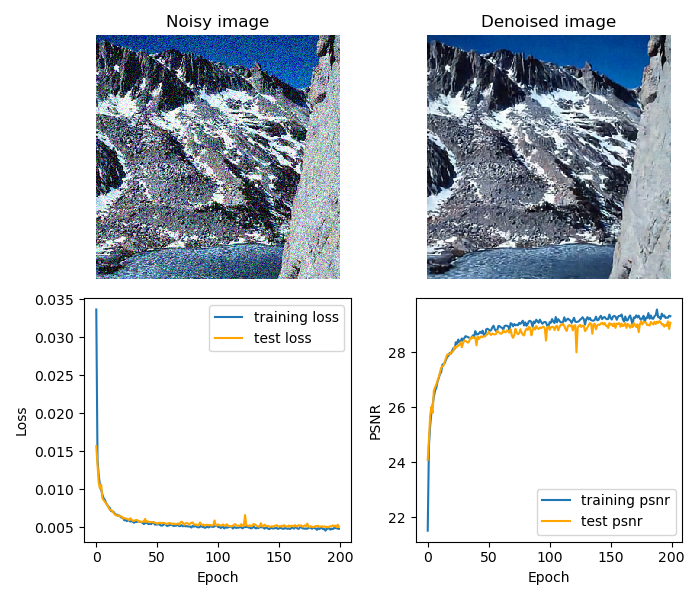

Start/Continue training from epoch 0
Epoch 1 (Time: 12.58s)
Epoch 2 (Time: 12.54s)
Epoch 3 (Time: 12.18s)
Epoch 4 (Time: 12.07s)
Epoch 5 (Time: 11.84s)
Epoch 6 (Time: 11.87s)
Epoch 7 (Time: 11.58s)
Epoch 8 (Time: 12.03s)
Epoch 9 (Time: 11.72s)
Epoch 10 (Time: 11.89s)
Epoch 11 (Time: 12.11s)
Epoch 12 (Time: 11.86s)
Epoch 13 (Time: 11.92s)
Epoch 14 (Time: 11.64s)
Epoch 15 (Time: 12.29s)
Epoch 16 (Time: 12.26s)
Epoch 17 (Time: 12.09s)
Epoch 18 (Time: 12.10s)
Epoch 19 (Time: 12.61s)
Epoch 20 (Time: 12.38s)
Epoch 21 (Time: 12.28s)
Epoch 22 (Time: 12.44s)
Epoch 23 (Time: 11.70s)
Epoch 24 (Time: 12.70s)
Epoch 25 (Time: 12.37s)
Epoch 26 (Time: 11.57s)
Epoch 27 (Time: 11.78s)
Epoch 28 (Time: 12.43s)
Epoch 29 (Time: 12.11s)
Epoch 30 (Time: 11.84s)
Epoch 31 (Time: 11.99s)
Epoch 32 (Time: 12.23s)
Epoch 33 (Time: 11.90s)
Epoch 34 (Time: 11.88s)
Epoch 35 (Time: 11.65s)
Epoch 36 (Time: 12.42s)
Epoch 37 (Time: 11.85s)
Epoch 38 (Time: 11.94s)
Epoch 39 (Time: 12.24s)
Epoch 40 (Time: 11.85s)
Epoch 41 (Ti

In [49]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7, 6))
exp2.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes, noisy=test_set[73][0]))

I have run the $2^{nd}$ experiment using $UDnCNN$ for Denosing on the GPU, with Adam Optimizer and with learning rate = $1^{-3}$. <br>
The training has been completed for $200$ epochs, and we have got $2$ plots, one each for loss and PSNR for the training and the testing set with the number of epochs. <br>
For each epoch, it takes about $12$ seconds to run on the GPU. <br>
I've also plotted a random noisy image from the test set and it's denoised version and tracked its evolution through the training over $200$ epochs.<br>

#### Question 14

$$\textbf{Number of Parameters Calculation}$$
The number of parameters of $UDnCNN$ are from the conv and batchnorm layers only. <br>
The pooling and unpooling layers do NOT contribute towards the total number of parameters. Hence, the number of parameters for $UDnCNN$ is the same number of parameters for $DnCNN$. <br>
The $1^{st}$ conv layer contributes $3*64*3*3 = 1728$ weight parameters. <br>
The $1^{st}$ conv layer contributes $64$ bias parameters, i.e., one parameter for each feature map. <br>
The next $D$ conv layers contribute $64*64*3*3 = 36864$ weight parameters each, totalling to $D*36864$ weight parameters. <br>
These $D$ conv layers contribute $64$ bias parameters each, totalling to $D*64$ bias parameters. <br>
The Batchnorm2d layer contributes $2$ parameters to each feature map, which is $64*2 = 128$ parameters. Then, $D$ layers contribute $128*D$ parameters. <br>
The final conv layer contributes $3*64*3*3 = 1728$ weight parameters. <br>
The final conv layer contributes $3$ bias parameters, i.e., one parameter for each feature map. <br>
The total number of parameters is thus as follows:-
$$\text{Number of parameters } = (3*64*3*3) + (64) + (D*64*64*3*3) + (D*64) + (D*64*2) + (3*64*3*3) + 3 = 37056D + 3523$$
For the specific case of $D=6$, the number of parameters is $37056*6 + 3523 = 225859$ <br>
$\textbf{We note that the number of parameters for UDnCNN is the same as that of DnCNN}$
$$\textbf{Receptive field calculation}$$
Calculating from input, each conv layer increases the receptive field by $2^{k-l+1} \times padding$, where $k$ is the number of pooling layers and $l$ is the number of unpooling layers before current convolution layer, and padding is the padding needed to keep the dimension constant after the convolution. <br>
So, the calculation for $D$ layers is as follows:-
$$\text{Receptive field of output } = 1 + 2 + \sum_{i=1}^{D/2} 2^i + \sum_{i=1}^{D/2} 2^i + 2$$
This is because in the contractive layers, the $1^{st}$ conv layer has no pooling before it, and the subsequent ones have $1$ pooling before each of them, leading to an increase in $k$ down the layers. <br>
In the expansive layers, the $1^{st}$ conv layer still has k pooling layers before it, but no unpooling layers.
The subsequent unpooling layers have $1$ unpooling layer before them each, leading to a constant $k$, but increasing $l$ through the layers. <br>
Hence, the receptive field of $DUDnCNN(D)$ is given by
$$\text{Receptive field } = 1 + 2 + \sum_{i=1}^{D/2} 2^i + \sum_{i=1}^{D/2} 2^i + 2 = 5 + 2\times\sum_{i=1}^{D/2} 2^i = \sum_{i=1}^{D/2} 2^{i+1} + 5$$
For the specific case of $D = 6$, we have receptive field = $\sum_{i=1}^{D/2} 2^{i+1} + 5 = \sum_{i=1}^{3} 2^{i+1} + 5 = 2^2 + 2^3 + 2^4 + 5 = 4 + 8 + 16 + 5 = 33$. <br>
$$\textbf{Inference}$$
We can expect $UDnCNN$ to beat $DnCNN$ because for the same number of parameters, the receptive field of the $UDnCNN$ is $\left( 33 \times 33\right)$, whereas the receptive field of $DnCNN$ is $\left( 17 \times 17\right)$. <br>
Question $11$ stated that Denoising literature claims that for reducing Gaussian noise of standard deviation $\sigma = 30$ effeciently a pixel should be influenced by atleast $33 \times 33$ pixels, which is achieved by $UDnCNN$. Hence, I expect the performance of $UDnCNN$ to be better.

#### Question 15

In [18]:
# evaluate the experiment
exp1_val = exp1.evaluate()
exp2_val = exp2.evaluate()

In [19]:
print(exp1_val)

{'loss': 0.0054100064653903246, 'psnr': tensor(28.7768, device='cuda:0')}


In [20]:
print(exp2_val)

{'loss': 0.0050600423384457825, 'psnr': tensor(29.0836, device='cuda:0')}


In [21]:
print("Loss of network on test set using DnCNN after 200 epochs is %.3f" % exp1_val['loss'])
print("PSNR of the network on test set using DnCNN after 200 epochs is %.3f" % exp1_val['psnr'].item())

Loss of network on test set using DnCNN after 200 epochs is 0.005
PSNR of the network on test set using DnCNN after 200 epochs is 28.777


In [22]:
print("Loss of network on test set using UDnCNN after 200 epochs is %.3f" % exp2_val['loss'])
print("PSNR of the network on test set using UDnCNN after 200 epochs is %.3f" % exp2_val['psnr'].item())

Loss of network on test set using UDnCNN after 200 epochs is 0.005
PSNR of the network on test set using UDnCNN after 200 epochs is 29.084


Comparing the performance of $UDnCNN$ with that of $DnCNN$, we find that $UDnCNN$ is only very very slightly better than $DnCNN$ <br>
The PSNR of $UDnCNN$ is $29.058$, which is higher than that of $DnCNN$, which is $28.849$ by $0.209$. <br>
The loss of $UDnCNN$ and that of $DnCNN$ is the same upto 3 decimal places, and the difference is just $0.00023$. <br>
This may be because for the same number of parameters, it's receptive field is high enough to perform well in the denoising task.

#### Question 16 and Question 17

In [14]:
class DUDnCNN(NNRegressor):
    
    def __init__(self, D, C=64):
        """ Constructor
        D - Number of repetiitons of Conv + BN + ReLU
        C - Number of feature maps for each Conv layer
            default - 64
        """
        super(DUDnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        
        # here padding=1 as we want to maintain the same size of the feature maps as given in input
        # this translates to "same" in convolutions, which means that we need to pad by (n-1)/2
        # hence, padding = (3-1)/2 = (2/2) = 1
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        # COMPLETE
        # I need to add D conv layers after this
        for k in range(D):
            if k == 0:
                self.conv.append(nn.Conv2d(C, C, 3, padding=1))
            elif k<D/2:
                self.conv.append(nn.Conv2d(C, C, 3, padding=2*k, dilation=2*k))
            elif k == D-1:
                self.conv.append(nn.Conv2d(C, C, 3, padding=1))
            else:
                self.conv.append(nn.Conv2d(C, C, 3, padding=2*(D-k-1), dilation=2*(D-k-1)))
        
        # Add the final conv from 64 back to 3 feature maps
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        # BN layers
        self.bn = nn.ModuleList()
        
        # Append all the D Batch norm layers
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C))
            
    def forward(self, x):
        D = self.D
        # list to store the features
        feats = []
        
        # Layer 1
        h = F.relu(self.conv[0](x))
        feats.append(h)
        # forward through D layers
        for k in range(D):
            # contractive layers
            if k < D/2 - 1:
                torch.backends.cudnn.benchmark = True
                h = self.conv[k+1](h)
                torch.backends.cudnn.benchmark = False
                h = F.relu(self.bn[k](h))
                feats.append(h)
            # expansive layers
            elif k >= D/2:
                torch.backends.cudnn.benchmark = True
                h = self.conv[k+1](h)
                torch.backends.cudnn.benchmark = False
                h = F.relu(self.bn[k](h))
                h = (h + feats[D-k-1]) / np.sqrt(2)
            # last contractive layer
            else:
                torch.backends.cudnn.benchmark = True
                h = self.conv[k+1](h)
                torch.backends.cudnn.benchmark = False
                h = F.relu(self.bn[k](h))
        
        # final layer forward
        # the x is added as a skip connection - ResNet
        y = self.conv[D+1](h) + x
        return y

I have now implemented the $DUDnCNN$ model, which inherits from $NNRegressor$. <br>
Here, we need to add dilated convolutions in U-net layers. <br>

$$\textbf{Adding the Conv layers}$$
We have $D = 6$ conv layers that repeat, so we iteratively append conv layers $D$ times, where each takes in $C$ features in the input, and outputs $C$ features. <br>
The conv layers in the contractive part, and the expansive part from index $1$ to index $D-2$ are dilated, and I have written the code as such. <br>
I also modified the padding for each layer appropriately. <br>
The final conv layer that is appended is the one that converts $C$ input features to $3$ output features back again. <br>
Thus, we have a total of $D + 2$ conv layers in the $self.conv$ $ModuleList$, which are indexed from $0$ to $D + 1$. <br>
$$\textbf{Adding the BatchNorm layers}$$
We have a total of $D$ $BatchNorm2d$ layers. We iteratively append bn layers $D$ times, where each takes in $C$ features in the input, to the $self.bn$ variable which is a $ModuleList$ object. <br>
Thus, we have a total of $D$ bn layers in the $self.bn$ $ModuleList$, which are indexed from $0$ to $D - 1$. <br>

$$\textbf{Implementing the forward() method}$$
In the $forward()$ method, as given in the question, I sequentially pass the input tensor $x$ through the $1^{st}$ conv layer, which is given by the index $0$ of the $self.conv$ $ModuleList$ object. <br>
I then iteratively pass the tensor obtained from the previous step through the $D$ conv layers first, and then through the $D$ BN layers. <br>
For the contractive layers, since the index is less than $(D/2)-1$ I store the features for the skip connection. <br>
For the expansive unpooling layers, since the index is greater than $(D/2)$, I perform Conv, BN and ReLU, and then add it to the feature map in the $(D-k-1)^{th}$ layer. <br>
Additionally, I add the $1^{st}$ expansive layers output with the feature map of the penultimate contractive layer before passing it on to the $1^{st}$ expansive layer. <br>
I then add the input tensor $x$ to this output, thus implementing my skip-connection. <br><br>
I finally implemented the $forward()$ method of my network and thus, this class is no longer an abstract class.

#### Question 18

In [15]:
# DUDnCNN network
lr = 1e-3

# create dncnn with D = 6
dudncnn_net = DUDnCNN(D=6)

# transferred the net to GPU
dudncnn_net = dudncnn_net.to(device)
adam = torch.optim.Adam(dudncnn_net.parameters(), lr=lr)
dudncnn_stats_manager = DenoisingStatsManager()
exp3 = nt.Experiment(dudncnn_net, train_set, test_set, adam,
                     dudncnn_stats_manager, output_dir="denoising3",
                     batch_size=4, perform_validation_during_training=True)

I have created a $DUDnCNN$ network with $D = 6$ and transferred it to the $GPU$. <br>
I also created and experiment for $DUDnCNN$ named $exp3$ using Adam optimizer with learning rate as $10^-3$. <br>
I am using an instance of the $DenoisingStatsManager$ class for computing statistics. <br>
Finally, I am using mini-batches of size $4$ and store the checkpoints in $denoising3$ directory. <br>
I finally checked that the directory has been created.

<IPython.core.display.Javascript object>


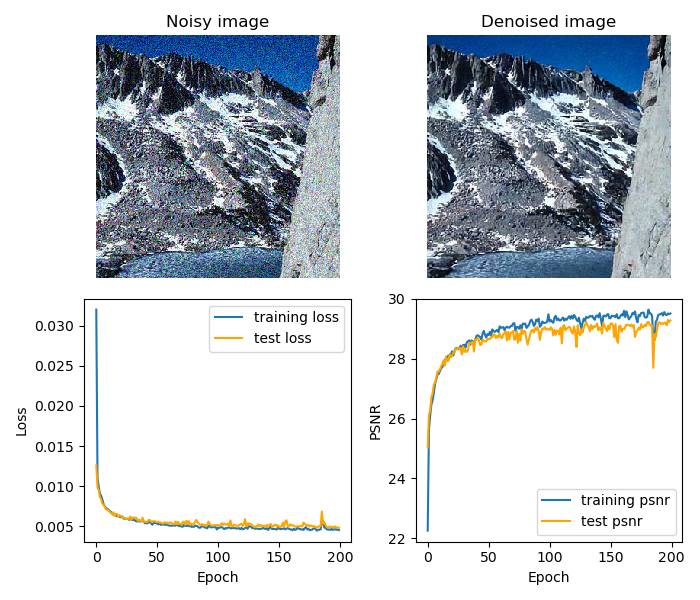

Start/Continue training from epoch 19
Epoch 20 (Time: 31.01s)
Epoch 21 (Time: 34.55s)
Epoch 22 (Time: 33.48s)
Epoch 23 (Time: 31.75s)
Epoch 24 (Time: 34.61s)
Epoch 25 (Time: 33.63s)
Epoch 26 (Time: 36.34s)
Epoch 27 (Time: 34.95s)
Epoch 28 (Time: 33.31s)
Epoch 29 (Time: 35.11s)
Epoch 30 (Time: 29.54s)
Epoch 31 (Time: 29.84s)
Epoch 32 (Time: 25.33s)
Epoch 33 (Time: 19.21s)
Epoch 34 (Time: 20.25s)
Epoch 35 (Time: 25.21s)
Epoch 36 (Time: 17.46s)
Epoch 37 (Time: 20.32s)
Epoch 38 (Time: 18.25s)
Epoch 39 (Time: 20.33s)
Epoch 40 (Time: 19.51s)
Epoch 41 (Time: 19.64s)
Epoch 42 (Time: 17.61s)
Epoch 43 (Time: 20.07s)
Epoch 44 (Time: 21.21s)
Epoch 45 (Time: 18.05s)
Epoch 46 (Time: 19.91s)
Epoch 47 (Time: 24.90s)
Epoch 48 (Time: 23.66s)
Epoch 49 (Time: 21.88s)
Epoch 50 (Time: 38.65s)
Epoch 51 (Time: 34.71s)
Epoch 52 (Time: 31.44s)
Epoch 53 (Time: 34.70s)
Epoch 54 (Time: 26.74s)
Epoch 55 (Time: 23.56s)
Epoch 56 (Time: 21.01s)
Epoch 57 (Time: 20.85s)
Epoch 58 (Time: 19.51s)
Epoch 59 (Time: 20.32s)
Ep

In [25]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7, 6))
exp3.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes, noisy=test_set[73][0]))

#### Question 19

In [26]:
exp1_val = exp1.evaluate()
exp2_val = exp2.evaluate()
exp3_val = exp3.evaluate()

In [27]:
print(exp1_val)
print(exp2_val)
print(exp3_val)

{'loss': 0.005352955600246787, 'psnr': tensor(28.8126, device='cuda:0')}
{'loss': 0.005020750733092427, 'psnr': tensor(29.1150, device='cuda:0')}
{'loss': 0.004855668880045414, 'psnr': tensor(29.2618, device='cuda:0')}


In [28]:
print("Loss of network on test set using DnCNN after 200 epochs is %.3f" % exp1_val['loss'])
print("PSNR of the network on test set using DnCNN after 200 epochs is %.3f" % exp1_val['psnr'].item())

Loss of network on test set using DnCNN after 200 epochs is 0.005
PSNR of the network on test set using DnCNN after 200 epochs is 28.813


In [29]:
print("Loss of network on test set using UDnCNN after 200 epochs is %.3f" % exp2_val['loss'])
print("PSNR of the network on test set using UDnCNN after 200 epochs is %.3f" % exp2_val['psnr'].item())

Loss of network on test set using UDnCNN after 200 epochs is 0.005
PSNR of the network on test set using UDnCNN after 200 epochs is 29.115


In [30]:
print("Loss of network on test set using DUDnCNN after 200 epochs is %.3f" % exp3_val['loss'])
print("PSNR of the network on test set using DUDnCNN after 200 epochs is %.3f" % exp3_val['psnr'].item())

Loss of network on test set using DUDnCNN after 200 epochs is 0.005
PSNR of the network on test set using DUDnCNN after 200 epochs is 29.262


Comparing the performance of $UDnCNN$ with that of $DnCNN$, we find that $UDnCNN$ is only very very slightly better than $DnCNN$ <br>
The PSNR of $UDnCNN$ is $29.115$, which is higher than that of $DnCNN$, which is $28.813$ by $0.302$. <br>
The loss of $UDnCNN$ and that of $DnCNN$ is the same upto 3 decimal places, and the difference is just $0.00033$. <br>
This may be because for the same number of parameters, it's receptive field is high enough to perform well in the denoising task. <br>
The performance of $DUDnCNN$ is the highest among all the $3$ networks. <br>
It's PSNR is $29.2618$ and it's loss is $0.0048$. Since it has the lowest loss and the highest PSNR, it is the best performing network for our task. <br>
One reason might be as given in the question. Even though the pooling layers increase the receptive field, they lose information about exact location. Hence, the alternative that we have used here is dilation, which increases the receptive field by dilating the convolutions that we perform.

$$\textbf{Comparative results between DnCNN, UDnCNN and DUDnCNN}$$

<IPython.core.display.Javascript object>


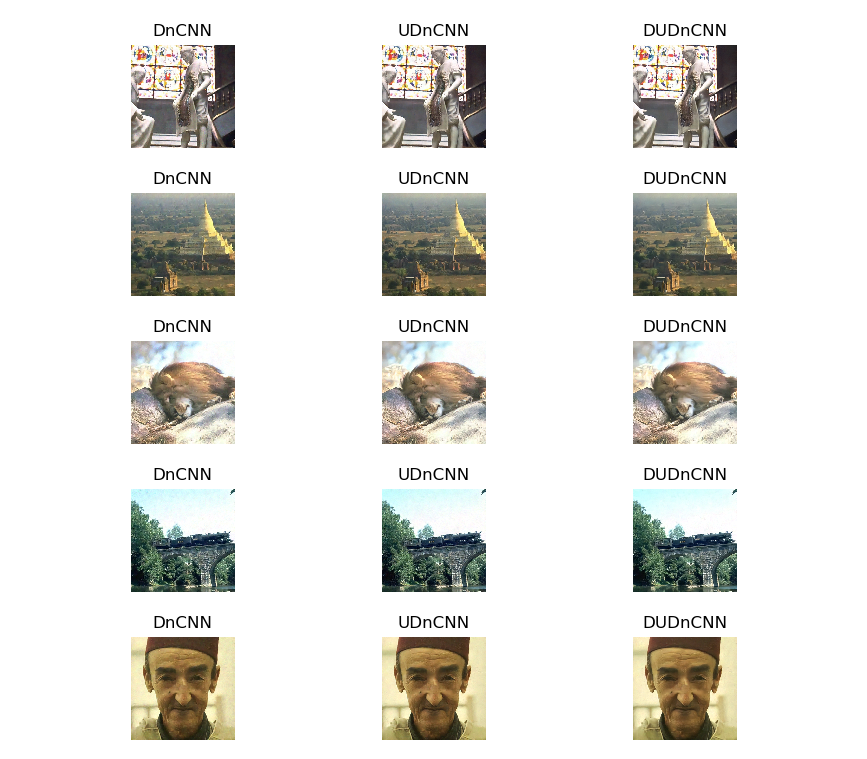

In [31]:
# Comparing the noisy, clean and denoised image results of a few images of the testing set
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(7, 6), sharex='all', sharey='all')
for i in range(5):
    ind = np.random.randint(0, len(test_set))
    noi, cle = test_set[ind]
    with torch.no_grad():
        den1 = exp1.net(noi[np.newaxis].to(exp1.net.device))[0]
        den2 = exp2.net(noi[np.newaxis].to(exp2.net.device))[0]
        den3 = exp3.net(noi[np.newaxis].to(exp3.net.device))[0]
    myimshow(den1, ax=axes[i][0])
    axes[i][0].set_title("DnCNN")
    # show the denoised image
    myimshow(den2, ax=axes[i][1])
    axes[i][1].set_title("UDnCNN")
    myimshow(den3, ax=axes[i][2])
    axes[i][2].set_title("DUDnCNN")
plt.tight_layout()
fig.canvas.draw()

I plotted the denoised image for $DnCNN$, $UDnCNN$ and $DUDnCNN$ for $5$ random indices from the test set. <br>
I find that the visual results are all almost the same, and that the denoised images are all almost equal in nature.

#### Question 20

$$\textbf{Number of Parameters Calculation}$$
The number of parameters of $DUDnCNN$ are from the conv and batchnorm layers only. <br>
The $1^{st}$ conv layer contributes $3*64*3*3 = 1728$ weight parameters. <br>
The $1^{st}$ conv layer contributes $64$ bias parameters, i.e., one parameter for each feature map. <br>
The next $D$ conv layers contribute $64*64*3*3 = 36864$ weight parameters each, totalling to $D*36864$ weight parameters. <br>
These $D$ conv layers contribute $64$ bias parameters each, totalling to $D*64$ bias parameters. <br>
The Batchnorm2d layer contributes $2$ parameters to each feature map, which is $64*2 = 128$ parameters. Then, $D$ layers contribute $128*D$ parameters. <br>
The final conv layer contributes $3*64*3*3 = 1728$ weight parameters. <br>
The final conv layer contributes $3$ bias parameters, i.e., one parameter for each feature map. <br>
The total number of parameters is thus as follows:-
$$\text{Number of parameters } = (3*64*3*3) + (64) + (D*64*64*3*3) + (D*64) + (D*64*2) + (3*64*3*3) + 3 = 37056D + 3523$$
For the specific case of $D=6$, the number of parameters is $37056*6 + 3523 = 225859$ <br>
$\textbf{We note that the number of parameters for DUDnCNN is the same as that of DnCNN, which is the same as that of UDnCNN}$
$$\textbf{Receptive field calculation}$$
The final conv layer, is $3*3$, so the receptive field of the output pixel to this layer is $3*3$. <br>
Now, for the $D$ layers, since the convolutions are dilated, we can consider that they are actually convolutions of higher kernel size.
For dilation of $2$, the kernel size is $\left(5\times5\right)$ and for dilation of $4$, the kernel size is $\left(9\times9\right)$. <br>
For kernel size of $5$, increase in receptive field is $4$, and for kernel size of $9$, increase in receptive field is $8$. <br>
Since the dilation increases as we go deeper into the contractive pathway, and dilation decreases as we move up the expansive pathway we can calculate for $D$ layers as follows:- 
$$\text{Receptive field of output } = 1 + 2 + \sum_{i=1}^{D/2} 2^i + \sum_{i=1}^{D/2} 2^i + 2$$
This is because in the contractive layers, the $1^{st}$ conv layer has no dilation, and the subsequent ones have powers of $2$ dilation. <br>
In the expansive layers, the $1^{st}$ conv layer still has $2^{D/2 - 1}$ dilation.
The subsequent unpooling layers have decreasing powers of $2$ dilation each <br>
Hence, the receptive field of $DUDnCNN(D)$ is given by
$$\text{Receptive field } = 1 + 2 + \sum_{i=1}^{D/2} 2^i + \sum_{i=1}^{D/2} 2^i + 2 = 5 + 2\times\sum_{i=1}^{D/2} 2^i = \sum_{i=1}^{D/2} 2^{i+1} + 5$$
For the specific case of $D = 6$, we have receptive field = $\sum_{i=1}^{D/2} 2^{i+1} + 5 = \sum_{i=1}^{3} 2^{i+1} + 5 = 2^2 + 2^3 + 2^4 + 5 = 4 + 8 + 16 + 5 = 33$. <br>
Hence, the receptive field is $33\times33$ for $D=6$.

### Observations
$$\textbf{Loss for experiments 1, 2, and 3}$$
The loss for $DnCNN$ network on the test set after $200$ epochs is $0.00535$. <br>
The loss for $UDnCNN$ network on the test set after $200$ epochs is $0.00502$. <br>
The loss for $DUDnCNN$ network on the test set after $200$ epochs is $0.00485$. <br>
$$\textbf{PSNR for the trained networks on the test set}$$
The PSNR for $DnCNN$ network on the test set after $200$ epochs is $28.8126$. <br>
The PSNR for $UDnCNN$ network on the test set after $200$ epochs is $29.1150$. <br>
The PSNR for $DUDnCNN$ network on the test set after $200$ epochs is $29.2618$. <br>
$$\textbf{Number of parameters for the networks}$$
The number of parameters is the same for all the $3$ networks, and is equal to $225859$. <br>
$$\textbf{Receptive field of the 3 networks}$$
The receptive field of $DnCNN(D)$ is $(2D + 5)\times(2D + 5)$. For $D = 6$, it is $17\times17$ <br>
The receptive field of $UDnCNN(D)$ is $\left(\sum_{i=1}^{D/2} 2^{i+1} + 5\right) \times \left(\sum_{i=1}^{D/2} 2^{i+1} + 5\right)$. For $D = 6$, it is $33 \times 33$. <br>
The receptive field of $DUDnCNN(D)$ is $\left(\sum_{i=1}^{D/2} 2^{i+1} + 5\right) \times \left(\sum_{i=1}^{D/2} 2^{i+1} + 5\right)$. For $D = 6$, it is $33 \times 33$. <br>

### Inferences
We infer that the performance of $DUDnCNN$ was the best followed closely by $UDnCNN$ and then finally $DnCNN$. <br>
$UDnCNN$ is slightly better than $DnCNN$ because it's receptive field is higher for the same number of parameters. As given in question $11$, a receptive field of atleast $33\times33$ is required to have good denoising results, which seems to be the case here. <br>
$DUDnCNN$ is better than $UDnCNN$ because for the same number of parameters, it's receptive field is $33\times33$. Also, as given in question $16$, since this network does not have pooling layers, it does not lose information about exact locations. This boosts denoising performance.

### Conclusion
We have learnt how to perform regression with Deep Networks. In particular, we learnt different methods that are used for denoising of images. <br>
Finally, we learnt to calculate the number of parameters, and also learnt how to calculate the receptive field of the networks that we use.

$$\textbf{Assignment completed by:-} \\
    \text{Name: Anirudh Swaminathan } \\
    \text{PID: A53316083 } \\
    \text{Email ID: aswamina@eng.ucsd.edu}$$